Using device: cuda
Training Policy Gradient (REINFORCE) Agent on CartPole-v1:
Episode 50/1500 | Avg Reward (Last 50): 24.48 | Loss: -0.0077
Episode 100/1500 | Avg Reward (Last 50): 31.04 | Loss: -0.0066
Episode 150/1500 | Avg Reward (Last 50): 40.58 | Loss: 0.0134
Episode 200/1500 | Avg Reward (Last 50): 54.06 | Loss: 0.0031
Episode 250/1500 | Avg Reward (Last 50): 66.90 | Loss: -0.0026
Episode 300/1500 | Avg Reward (Last 50): 131.94 | Loss: -0.0028
Episode 350/1500 | Avg Reward (Last 50): 182.86 | Loss: 0.0180
Episode 400/1500 | Avg Reward (Last 50): 235.34 | Loss: -0.0192
Episode 450/1500 | Avg Reward (Last 50): 300.30 | Loss: -0.0255
Episode 500/1500 | Avg Reward (Last 50): 295.02 | Loss: -0.0133
Episode 550/1500 | Avg Reward (Last 50): 358.46 | Loss: -0.0203
Episode 600/1500 | Avg Reward (Last 50): 420.66 | Loss: -0.0160
Episode 650/1500 | Avg Reward (Last 50): 378.84 | Loss: 0.0005
Episode 700/1500 | Avg Reward (Last 50): 453.66 | Loss: 0.0122
Episode 750/1500 | Avg Reward (Last 5

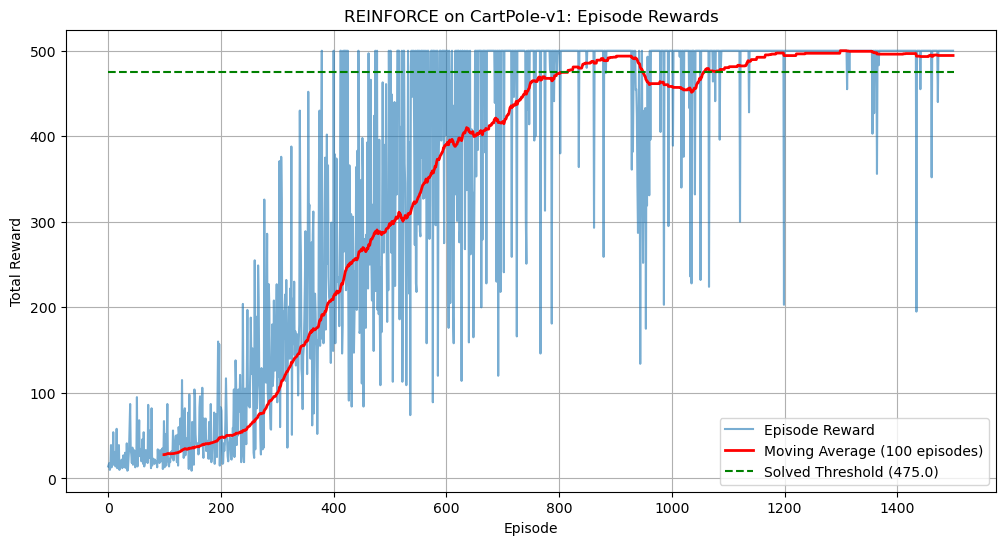

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

class PolicyGradientAgentDiscrete(nn.Module): 
    def __init__(self, state_size, action_size, hidden_size, lr):
        super().__init__() 
        self.state_size = state_size     
        self.action_size = action_size  
        self.hidden_size = hidden_size 

        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size) 

        self.optimizer = optim.AdamW(self.parameters(), lr=lr)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        logits = self.fc2(x)
        return logits 

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)

        with torch.no_grad():
            logits = self.forward(state)
            probs = torch.softmax(logits, dim=-1) 
            action = torch.multinomial(probs, num_samples=1).squeeze()

        return action

    def train(self, states, actions, rewards, gamma):
        returns = []
        discounted_reward = 0 

        for r in reversed(rewards):
            discounted_reward = r + gamma * discounted_reward
            returns.insert(0, discounted_reward)

        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        states_tensor = torch.stack(states).to(device) 
        actions_tensor = torch.stack(actions).to(device) 

        returns = (returns - returns.mean()) / (returns.std() + 1e-8) 

        logits = self.forward(states_tensor)
        probs = torch.softmax(logits, dim=-1) 

        actions_tensor = actions_tensor.long().unsqueeze(-1) 
        action_probs = probs.gather(dim=-1, index=actions_tensor).squeeze(-1)

        log_probs = torch.log(action_probs + 1e-8)
        loss = -(log_probs * returns).mean() 

        self.optimizer.zero_grad() 
        loss.backward()          
        self.optimizer.step()     

        return loss.item() 

def train_agent_cartpole(episodes=1000, hidden_size=64, lr=1e-3, gamma=0.99, print_every=50, save_path="best_reinforce_agent.pth"): 
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0] 
    action_size = env.action_space.n          

    agent = PolicyGradientAgentDiscrete(state_size, action_size, hidden_size, lr).to(device)

    episode_rewards = [] 
    recent_rewards = [] 

    best_avg_reward = -float('inf') 

    for episode in range(episodes):
        state_np, info = env.reset() 
        states_memory, actions_memory, rewards_memory = [], [], []
        total_reward = 0

        for t in range(env.spec.max_episode_steps): 
            action_tensor = agent.get_action(state_np) 
            action_int = action_tensor.item() 

            next_state_np, reward, terminated, truncated, info = env.step(action_int)

            state_tensor = torch.tensor(state_np, dtype=torch.float32).to(device) 
            states_memory.append(state_tensor)
            actions_memory.append(action_tensor) 
            rewards_memory.append(reward)

            state_np = next_state_np 
            total_reward += reward

            if terminated or truncated:
                break 

        loss = agent.train(states_memory, actions_memory, rewards_memory, gamma) 

        episode_rewards.append(total_reward)
        recent_rewards.append(total_reward) 

        if len(recent_rewards) > print_every:
             recent_rewards.pop(0)

        current_avg_reward = np.mean(recent_rewards)

        if current_avg_reward > best_avg_reward:
            best_avg_reward = current_avg_reward 
            torch.save(agent.state_dict(), save_path)

        if (episode + 1) % print_every == 0:
            print(f"Episode {episode + 1}/{episodes} | Avg Reward (Last {len(recent_rewards)}): {current_avg_reward:.2f} | Loss: {loss:.4f}")
                
    print(f"New best model saved with avg reward: {best_avg_reward:.2f}")
    env.close()
    return agent, episode_rewards

def plot_rewards(rewards, window=100):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward', alpha=0.6)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(np.arange(window-1, len(rewards)), moving_avg, label=f'Moving Average ({window} episodes)', color='red', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE on CartPole-v1: Episode Rewards')
    reward_threshold = gym.spec("CartPole-v1").reward_threshold
    if plt.ylim()[1] > reward_threshold * 0.8 :
        plt.hlines(reward_threshold, 0, len(rewards), colors='g', linestyles='dashed', label=f'Solved Threshold ({reward_threshold})')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    torch.manual_seed(42) 

    print("Training Policy Gradient (REINFORCE) Agent on CartPole-v1:")
    save_file_path = "best_reinforce_cartpole.pth" 

    trained_agent, rewards_history = train_agent_cartpole(
        episodes=1500, 
        hidden_size=64,
        lr=2e-3,    
        gamma=0.99,   
        print_every=50,
        save_path=save_file_path
    )

    plot_rewards(rewards_history)

In [ ]:
render_env_temp = gym.make('CartPole-v1')
state_size_render = render_env_temp.observation_space.shape[0]
action_size_render = render_env_temp.action_space.n
render_env_temp.close()

best_agent = PolicyGradientAgentDiscrete(state_size_render, action_size_render, hidden_size=64, lr=0).to(device) 

best_agent.load_state_dict(torch.load(save_file_path, map_location=device))

render_env = gym.make('CartPole-v1', render_mode='human')

num_render_episodes = 3 
max_steps = 500 

for episode in range(num_render_episodes):
    state_np, info = render_env.reset(seed=100 + episode)
    total_reward = 0
    terminated = False
    truncated = False
    step_count = 0
    
    while not terminated and not truncated and step_count < max_steps:
        action_tensor = best_agent.get_action(state_np)
        action = action_tensor.item() 

        state_np, reward, terminated, truncated, info = render_env.step(action)
        total_reward += reward
        step_count += 1

    print(f"Rendered Episode {episode + 1} | Total Reward: {total_reward}")

render_env.close()

Rendered Episode 1 | Total Reward: 284.0
Rendered Episode 2 | Total Reward: 500.0
Rendered Episode 3 | Total Reward: 500.0


Using device: cuda
Training  A2C Agent on Pendulum-v1:
Ep   100 | Steps   20000 | Avg Rwd (last 100 ep): -1458.3 | Best Avg Rwd: -1317.4 | Avg A_Loss: -0.0162 | Avg C_Loss:  0.5171 | Entropy: 1.4184
Ep   200 | Steps   40000 | Avg Rwd (last 100 ep): -1460.9 | Best Avg Rwd: -1317.4 | Avg A_Loss: -0.0029 | Avg C_Loss:  0.1550 | Entropy: 1.4190
Ep   300 | Steps   60000 | Avg Rwd (last 100 ep): -1421.5 | Best Avg Rwd: -1317.4 | Avg A_Loss:  0.0042 | Avg C_Loss:  0.4648 | Entropy: 1.4211
Ep   400 | Steps   80000 | Avg Rwd (last 100 ep): -1325.0 | Best Avg Rwd: -1313.5 | Avg A_Loss:  0.0074 | Avg C_Loss:  0.9457 | Entropy: 1.4260
Ep   500 | Steps  100000 | Avg Rwd (last 100 ep): -1351.3 | Best Avg Rwd: -1313.5 | Avg A_Loss: -0.0113 | Avg C_Loss:  0.7950 | Entropy: 1.4284
Ep   600 | Steps  120000 | Avg Rwd (last 100 ep): -1225.4 | Best Avg Rwd: -1222.6 | Avg A_Loss: -0.0176 | Avg C_Loss:  1.8035 | Entropy: 1.4268
Ep   700 | Steps  140000 | Avg Rwd (last 100 ep): -1117.0 | Best Avg Rwd: -1092.4

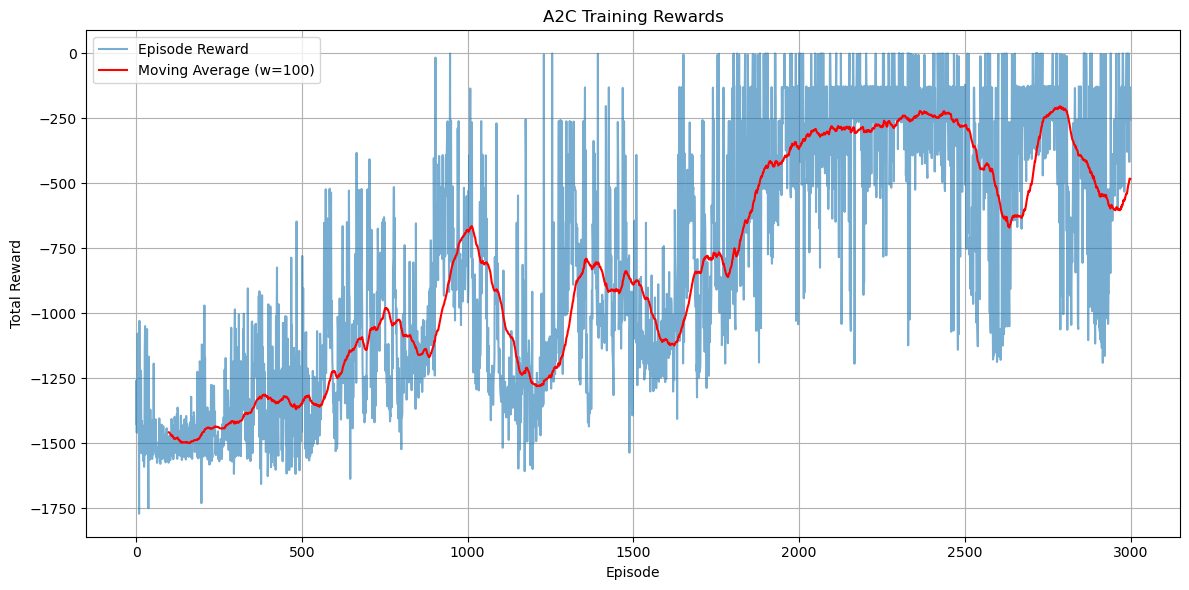

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt 

class Actor(nn.Module):
    def __init__(self, state_size, hidden_size, action_bound):
        super().__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size
        self._action_bound = action_bound

        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc_actor_mean = nn.Linear(hidden_size, 1)

        self.actor_log_std = nn.Parameter(torch.zeros(1))

    def forward(self, state):
        state = state.to(device)

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        mean = torch.tanh(self.fc_actor_mean(x)) * self._action_bound
        log_std = self.actor_log_std.expand_as(mean)
        std = torch.exp(log_std) 

        return mean, std

    def get_action(self, state, deterministic=False):
        if state.dim() == 1: 
             state = state.unsqueeze(0)
        state = state.to(device)

        with torch.no_grad():
            mean, std = self.forward(state)
            normal_dist = Normal(mean, std)
            if deterministic:
                action = mean 
            else:
                action = normal_dist.sample() 
        return action.squeeze(0)

class Critic(nn.Module):
    def __init__(self, state_size, hidden_size):
        super().__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc_critic = nn.Linear(hidden_size, 1)

    def forward(self, state):
        state = state.to(device)

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        value = self.fc_critic(x)

        return value

class A2CAgent:
    def __init__(self, state_size, hidden_size, action_bound, actor_lr=1e-4, critic_lr=5e-4, gamma=0.99, entropy_coef=0.01):
        self.gamma = gamma
        self.entropy_coef = entropy_coef

        self.actor = Actor(state_size, hidden_size, action_bound).to(device)
        self.critic = Critic(state_size, hidden_size).to(device)

        self.optimizer_actor = optim.AdamW(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic = optim.AdamW(self.critic.parameters(), lr=critic_lr)

    def train_step(self, states, actions, rewards, next_states, dones):
        states = torch.stack(states).to(device)
        actions = torch.stack(actions).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
        next_states = torch.stack(next_states).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

        values = self.critic(states)
        next_values = self.critic(next_states)

        td_targets = rewards + self.gamma * next_values * (1 - dones)
        critic_loss = F.mse_loss(values, td_targets.detach())

        advantages = td_targets - values
        advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        means, stds = self.actor(states)
        dist = Normal(means, stds)
        log_probs = dist.log_prob(actions)

        policy_loss = -(log_probs * advantages_normalized.detach()).mean()

        entropy = dist.entropy().mean()
        actor_loss = policy_loss - self.entropy_coef * entropy

        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        return actor_loss.item(), critic_loss.item(), entropy.item()

def train_agent_a2c(
    episodes=3000,
    batch_size=32,
    hidden_size=128,
    actor_lr=1e-4,       
    critic_lr=5e-4,      
    gamma=0.99,         
    print_every=100,
    entropy_coef=0.005,   
    save_actor_filename="a2c_pendulum_actor_best.pth", 
    save_critic_filename="a2c_pendulum_critic_best.pth" 
    ):

    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_bound = env.action_space.high[0]

    agent = A2CAgent(
        state_size=state_size, hidden_size=hidden_size, action_bound=action_bound,
        actor_lr=actor_lr, critic_lr=critic_lr, gamma=gamma, entropy_coef=entropy_coef
    )

    episode_rewards = []
    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = [], [], [], [], []
    update_actor_losses, update_critic_losses, update_entropies= [], [], []

    best_avg_reward = -float('inf')
    total_steps = 0

    for episode in range(episodes):
        state_np, info = env.reset(seed=42 + episode)
        state = torch.tensor(state_np, dtype=torch.float32).to(device)
        episode_reward_raw = 0

        while True: 
            action_tensor = agent.actor.get_action(state) 
            action_np = action_tensor.cpu().numpy()
            next_state_np, reward_raw, terminated, truncated, info = env.step(action_np)
            done = terminated or truncated
            total_steps += 1
            reward_normalized = (reward_raw + 8.0)/ 8.0 

            next_state = torch.tensor(next_state_np, dtype=torch.float32).to(device)
            batch_states.append(state); batch_actions.append(action_tensor); batch_rewards.append(reward_normalized); batch_next_states.append(next_state); batch_dones.append(done)
            state = next_state
            episode_reward_raw += reward_raw

            if len(batch_states) >= batch_size:
                actor_loss, critic_loss, entropy = agent.train_step(
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
                )
                update_actor_losses.append(actor_loss)
                update_critic_losses.append(critic_loss)
                update_entropies.append(entropy)

                batch_states.clear(); batch_actions.clear(); batch_rewards.clear(); batch_next_states.clear(); batch_dones.clear()

            if done:

                if batch_states:
                    actor_loss, critic_loss, entropy = agent.train_step(
                         batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
                    )
                    update_actor_losses.append(actor_loss)
                    update_critic_losses.append(critic_loss)
                    update_entropies.append(entropy)

                    batch_states.clear(); batch_actions.clear(); batch_rewards.clear(); batch_next_states.clear(); batch_dones.clear()
                break 

        episode_rewards.append(episode_reward_raw)

        if len(episode_rewards) >= print_every:
            avg_reward_raw = np.mean(episode_rewards[-print_every:])
        else:
            avg_reward_raw = np.mean(episode_rewards)

        if avg_reward_raw > best_avg_reward:
            best_avg_reward = avg_reward_raw
            torch.save(agent.actor.state_dict(), save_actor_filename)
            torch.save(agent.critic.state_dict(), save_critic_filename)

        if (episode+1) % print_every == 0:
            avg_actor_loss = np.mean(update_actor_losses)
            avg_critic_loss = np.mean(update_critic_losses)
            avg_entropy = np.mean(update_entropies)

            update_actor_losses.clear(); update_critic_losses.clear(); update_entropies.clear()

            print(f"Ep {episode+1:5d} | Steps {total_steps:7d} | Avg Rwd (last {min(print_every, len(episode_rewards))} ep): {avg_reward_raw:7.1f} | "
                  f"Best Avg Rwd: {best_avg_reward:.1f} | Avg A_Loss: {avg_actor_loss:7.4f} | Avg C_Loss: {avg_critic_loss:7.4f} | Entropy: {avg_entropy:6.4f}")

    env.close()
    print(f"\nTraining finished. Best models saved to {save_actor_filename} and {save_critic_filename} with average reward: {best_avg_reward:.2f}")
    return agent, episode_rewards

def plot_rewards(rewards, window=100):
    """Plots episode rewards with a moving average."""
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward', alpha=0.6)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(np.arange(window-1, len(rewards)), moving_avg, label=f'Moving Average (w={window})', color='red')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("A2C Training Rewards")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    torch.manual_seed(42)

    print("Training  A2C Agent on Pendulum-v1:")

    trained_agent, rewards_history = train_agent_a2c(
        episodes=3000,        
        batch_size=128,         
        hidden_size=256,    
        actor_lr=1e-4,        
        critic_lr=5e-4,        
        gamma=0.99,
        print_every=100,
        entropy_coef=0.005,
        save_actor_filename="best_a2c_pendulum_actor.pth",
        save_critic_filename="best_a2c_pendulum_critic.pth"
    )

    plot_rewards(rewards_history, window=100) 

In [ ]:
hidden_size = 256  
actor_filepath = "best_a2c_pendulum_actor.pth"
critic_filepath = "best_a2c_pendulum_critic.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

temp_env = gym.make('Pendulum-v1')
state_size = temp_env.observation_space.shape[0]
action_bound = temp_env.action_space.high[0]
temp_env.close() 

best_agent = A2CAgent(state_size, hidden_size, action_bound)

best_agent.actor.load_state_dict(torch.load(actor_filepath, map_location=device))
best_agent.critic.load_state_dict(torch.load(critic_filepath, map_location=device))

best_agent.actor.to(device)
best_agent.critic.to(device)

render_env = gym.make('Pendulum-v1', render_mode='human')

num_render_episodes = 3  
max_steps = 200        

for episode in range(num_render_episodes):
    state_np, info = render_env.reset(seed=100 + episode)
    total_reward = 0
    terminated = False
    truncated = False
    step_count = 0

    while not terminated and not truncated and step_count < max_steps:
        render_env.render() 
        state_tensor = torch.tensor(state_np, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            action_tensor = best_agent.actor.get_action(state_tensor, deterministic=True)

        action_np = action_tensor.cpu().numpy().flatten()

        next_state_np, reward, terminated, truncated, info = render_env.step(action_np)
        total_reward += reward
        state_np = next_state_np 
        step_count += 1

    print(f"Rendered Episode {episode + 1} | Total Reward: {total_reward:.2f}")

render_env.close()

Rendered Episode 1 | Total Reward: -129.88
Rendered Episode 2 | Total Reward: -352.84
Rendered Episode 3 | Total Reward: -264.34
